In [71]:
import pandas as pd
import pydicom
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import os
import re
import zipfile
from pydicom.pixel_data_handlers.util import apply_voi_lut, apply_modality_lut
import pydicom.pixel_data_handlers.util as dh
from pydicom import dcmread
import glob
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
import scipy.ndimage as ndi

In [24]:

#!pip install pydicom
#!pip3 install opencv-python

In [25]:
BASE = '/Users/rps/Downloads/MV_1149275'
DPATH = os.path.join(BASE, 'DICOM')
files =glob.glob(os.path.join(DPATH,'*' ))
files[:2]

['/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500000946.dcm',
 '/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001480.dcm']

![alt s](./windowsCT.png){width = 500}


In [26]:
from IPython.display import Image
Image(url='./windows_CT.png', width=2000)

<img src="./windowsCT.png" alt="Drawing" style="width: 2000px;"/>

array([[-8192.        , -8192.        , -8192.        , ...,
        -8192.        , -8192.        , -8192.        ],
       [-8192.        , -8192.        , -8192.        , ...,
        -8192.        , -8192.        , -8192.        ],
       [-8192.        , -8192.        , -8192.        , ...,
        -8192.        , -8192.        , -8192.        ],
       ...,
       [-6049.76184123, -1371.81320881,   857.86324216, ...,
         2956.38225484,  2694.06737825,  2344.31420947],
       [ 4093.08005337,  6891.1054036 ,  6585.07138092, ...,
         3174.97798532,  1426.21214143,  1120.17811875],
       [ 5448.37358239,  4442.83322215,  2694.06737825, ...,
         3524.7311541 ,  4399.11407605,  4311.67578386]])

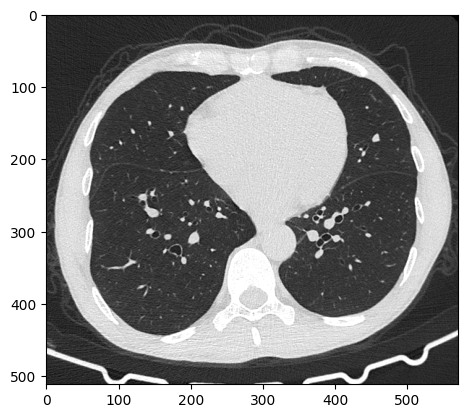

In [69]:
ds = pydicom.dcmread(files[0])
#img = ds.pixel_array # dtype = uint16
# img = img.astype(float)
# img = img*ds.RescaleSlope + ds.RescaleIntercept
#img = dh.(ds.pixel_array,ds)
#img = dh.apply_voi_lut(ds.pixel_array,ds)

img = dh.apply_modality_lut(ds.pixel_array, ds)
img = dh.apply_windowing(img,ds)

#img = img*ds.RescaleSlope + ds.RescaleIntercept
#img[ img > 20000]=20000
def apply_ct_window(img, window):
    # window = (window width, window level)
    R = (img-window[1]+0.5*window[0])/window[0]
    R[R<0] = 0
    R[R>1] = 1
    return R
#display_img = apply_ct_window(img, [1600,-600])
display_img = img
# dcm = pydicom.read_file(files[0])
# x = dcm.pixel_array
plt.imshow(display_img,cmap= plt.cm.gray )
#plt.imsave(display_img, 'teste.png', cmap = plt.cm.gray)
display_img


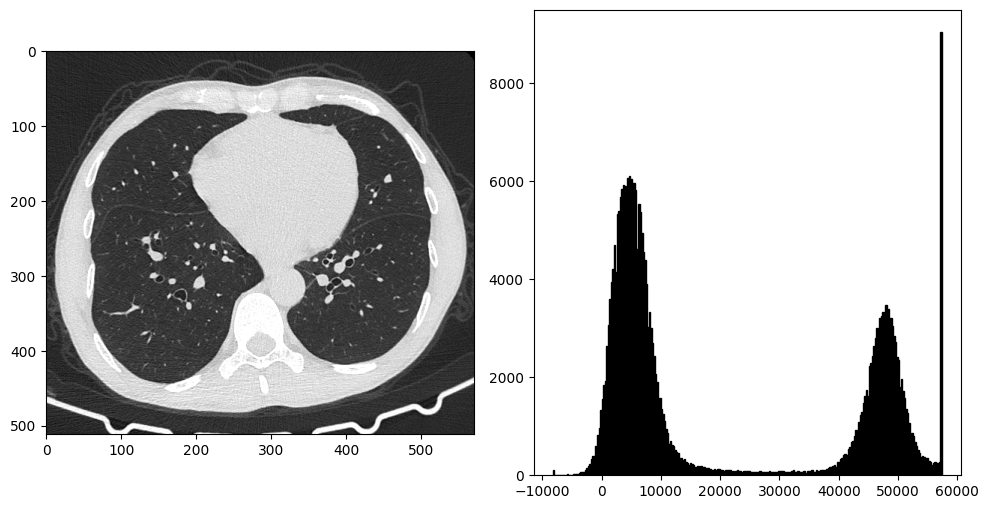

In [70]:
fig1 = plt.figure(1,figsize=(10, 10))
fig1.add_subplot(2, 2, 1)
plt.imshow(display_img,cmap= plt.cm.gray )
fig1.add_subplot(2, 2, 2)
plt.hist(display_img.ravel(),bins=256, fc='k', ec='k')
plt.tight_layout()
plt.imsave( 'testea.png',display_img,cmap= plt.cm.gray )

In [81]:
# import plotly.express as px
# fig = px.imshow(display_img)
# fig

In [84]:
def read_dicomR(path):
    ds = pydicom.dcmread(path)
    img = dh.apply_modality_lut(ds.pixel_array, ds)
    img = dh.apply_windowing(img,ds)
    return img
#img = img*ds.RescaleSlope + ds.RescaleIntercept
# def apply_ct_window(img, window):
#     # window = (window width, window level)
#     R = (img-window[1]+0.5*window[0])/window[0]
#     R[R<0] = 0
#     R[R>1] = 1
#     return R
#display_img = apply_ct_window(img, [1600,-600])
# display_img = img
# # dcm = pydicom.read_file(files[0])
# # x = dcm.pixel_array
# plt.imshow(display_img,cmap= plt.cm.gray )
# #plt.imsave(display_img, 'teste.png', cmap = plt.cm.gray)
# display_img

In [82]:
# def read_xray(path, voi_lut = True, fix_monochrome = True):
#     dicom = pydicom.read_file(path)
#
#     # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
#     if voi_lut:
#         data = apply_voi_lut(dicom.pixel_array, dicom)
#     else:
#         data = dicom.pixel_array
#
#     # depending on this value, X-ray may look inverted - fix that:
#     if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
#         data = np.amax(data) - data
#
#     data = data - np.min(data)
#     data = data / np.max(data)
#     data = (data * 255).astype(np.uint8)
#
#     return data
# img = read_xray(files[0])
# plt.imshow(img, cmap= plt.cm.gray)
# img

## Lets find the scout and other bugged files:

In [77]:
def get_observation_data(path):
    """Get information from the .dcm files.
    path: complete path to the .dcm file"""

    image_data = pydicom.read_file(path)
    if image_data.get('PhotometricInterpretation') is None:
        return AttributeError

    # Dictionary to store the information from the image
    observation_data = {
        "FileNumber" : path.split("/")[5],
        "Rows" : image_data.get("Rows"),
        "Columns" : image_data.get("Columns"),
        "PatientID" : image_data.get("PatientID"),
        "BodyPartExamined" : image_data.get("BodyPartExamined"),
        "RotationDirection" : image_data.get("RotationDirection"),
        "ConvolutionKernel" : image_data.get("ConvolutionKernel"),
        "PatientPosition" : image_data.get("PatientPosition"),
        "PhotometricInterpretation" : image_data.get("PhotometricInterpretation"),
        "Modality" : image_data.get("Modality"),
        "StudyInstanceUID" : image_data.get("StudyInstanceUID"),
        "PixelPaddingValue" : image_data.get("PixelPaddingValue"),
        "SamplesPerPixel" : image_data.get("SamplesPerPixel"),
        "BitsAllocated" : image_data.get("BitsAllocated"),
        "BitsStored" : image_data.get("BitsStored"),
        "HighBit" : image_data.get("HighBit"),
        "PixelRepresentation" : image_data.get("PixelRepresentation"),
        "RescaleType" : image_data.get("RescaleType"),
    }

    # Integer columns
    int_columns = ["SliceThickness", "KVP", "DistanceSourceToDetector",
        "DistanceSourceToPatient", "GantryDetectorTilt", "TableHeight",
        "XRayTubeCurrent", "GeneratorPower", "WindowCenter", "WindowWidth",
        "SliceLocation", "RescaleIntercept", "RescaleSlope"]
    for k in int_columns:
        observation_data[k] = int(image_data.get(k)) if k in image_data else None

    # String columns
    str_columns = ["ImagePositionPatient", "ImageOrientationPatient", "ImageType", "PixelSpacing"]
    for k in str_columns:
        observation_data[k] = str(image_data.get(k)) if k in image_data else None


    return observation_data

In [78]:
examples = []
bugged = []
files_read = []
for x in files:
    try:
        ans0 = pydicom.read_file(x)
        ansx = ans0.pixel_array
        ans = get_observation_data(x)
    except:
        bugged.append(x)
        continue
    examples.append(ans )
    files_read.append(x)
#pd.DataFrame(examples)

In [79]:
#x = [get_observation_data(s) for s in files]
len(files), len(examples),len(bugged),bugged


(1295,
 1292,
 3,
 ['/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001523.dcm',
  '/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001519.dcm',
  '/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500000157.dcm'])

In [80]:
df = pd.DataFrame(examples)
df['id']= df['Rows'].astype(str) + df['Columns'].astype(str)
df['path'] = files_read
# lets group by expositions
groups = df.id.unique()
df, groups

(     FileNumber  Rows  Columns PatientID BodyPartExamined RotationDirection  \
 0         DICOM   512      571  12835024            CHEST                CW   
 1         DICOM   655      512  12835024            CHEST                CW   
 2         DICOM   512      571  12835024            CHEST                CW   
 3         DICOM   655      512  12835024            CHEST                CW   
 4         DICOM   512      571  12835024            CHEST                CW   
 ...         ...   ...      ...       ...              ...               ...   
 1287      DICOM   512      571  12835024            CHEST                CW   
 1288      DICOM   512      571  12835024            CHEST                CW   
 1289      DICOM   512      571  12835024            CHEST                CW   
 1290      DICOM   512      571  12835024            CHEST                CW   
 1291      DICOM   655      512  12835024            CHEST                CW   
 
      ConvolutionKernel PatientPositio

In [177]:
# import matplotlib.pyplot as plt
# from pydicom import dcmread
# from pydicom.data import get_testdata_file
#
# #fpath = get_testdata_file('CT_small.dcm')
# ds = dcmread(files[0])
#
# # Normal mode:
# print()
# print(f"File path........: {fpath}")
# print(f"SOP Class........: {ds.SOPClassUID} ({ds.SOPClassUID.name})")
# print()
#
# pat_name = ds.PatientName
# print(f"Patient's Name...: {pat_name.family_comma_given()}")
# print(f"Patient ID.......: {ds.PatientID}")
# print(f"Modality.........: {ds.Modality}")
# print(f"Study Date.......: {ds.StudyDate}")
# print(f"Image size.......: {ds.Rows} x {ds.Columns}")
# print(f"Pixel Spacing....: {ds.PixelSpacing}")
#
# # use .get() if not sure the item exists, and want a default value if missing
# print(f"Slice location...: {ds.get('SliceLocation', '(missing)')}")
#
# # plot the image using matplotlib
# plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
# plt.show()

In [91]:
# import pydicom
# import numpy as np
# import matplotlib.pyplot as plt
# import sys
# import glob
#
# # load the DICOM files
# files = []
# print('glob: {}'.format(sys.argv[1]))
# for fname in glob.glob(sys.argv[1], recursive=False):
#     print("loading: {}".format(fname))
#     files.append(pydicom.dcmread(fname))
#
# print("file count: {}".format(len(files)))
#
# # skip files with no SliceLocation (eg scout views)
# slices = []
# skipcount = 0
# for f in files:
#     if hasattr(f, 'SliceLocation'):
#         slices.append(f)
#     else:
#         skipcount = skipcount + 1
#
# print("skipped, no SliceLocation: {}".format(skipcount))
#
# # ensure they are in the correct order
# slices = sorted(slices, key=lambda s: s.SliceLocation)
#
# # pixel aspects, assuming all slices are the same
# ps = slices[0].PixelSpacing
# ss = slices[0].SliceThickness
# ax_aspect = ps[1]/ps[0]
# sag_aspect = ps[1]/ss
# cor_aspect = ss/ps[0]
#
# # create 3D array
# img_shape = list(slices[0].pixel_array.shape)
# img_shape.append(len(slices))
# img3d = np.zeros(img_shape)
#
# # fill 3D array with the images from the files
# for i, s in enumerate(slices):
#     img2d = s.pixel_array
#     img3d[:, :, i] = img2d
#
# # plot 3 orthogonal slices
# a1 = plt.subplot(2, 2, 1)
# plt.imshow(img3d[:, :, img_shape[2]//2])
# a1.set_aspect(ax_aspect)
#
# a2 = plt.subplot(2, 2, 2)
# plt.imshow(img3d[:, img_shape[1]//2, :])
# a2.set_aspect(sag_aspect)
#
# a3 = plt.subplot(2, 2, 3)
# plt.imshow(img3d[img_shape[0]//2, :, :].T)
# a3.set_aspect(cor_aspect)
#
# plt.show()

In [92]:
# def read_dicom( filepath):
#     ds = pydicom.dcmread(filepath)
#     img = ds.pixel_array # dtype = uint16
#     img = apply_modality_lut(img, dcm)
#     img = img.astype(float)
#     #img = img*ds.RescaleSlope + ds.RescaleIntercept
#
#     def apply_ct_window(img, window):
#         # window = (window width, window level)
#         R = (img-window[1]+0.5*window[0])/window[0]
#         R[R<0] = 0
#         R[R>1] = 1
#         return R
#     img = apply_ct_window(img, [1600,-600])  # lung window
#     return img
#
#     # dcm = pydicom.read_file(filepath)
#     # img = dcm.pixel_array
#     # if modality_lut == True:
#     #     img = apply_modality_lut(dcm.pixel_array, dcm)
#     # max_img = np.max(img)
#     # min_img = np.min(img)
#     # if fix_monochrome == True and dcm.PhotometricInterpretation=='MONOCHROME1':
#     #     img = max_img - img
#     # img = (img - np.min(img))/(max_img - min_img)
#     # img = (img * 255).astype(np.uint8)
#     # return img

array([[-8192.        , -8192.        , -8192.        , ...,
        -8192.        , -8192.        , -8192.        ],
       [-8192.        , -8192.        , -8192.        , ...,
        -8192.        , -8192.        , -8192.        ],
       [-8192.        , -8192.        , -8192.        , ...,
        -8192.        , -8192.        , -8192.        ],
       ...,
       [-6049.76184123, -1371.81320881,   857.86324216, ...,
         2956.38225484,  2694.06737825,  2344.31420947],
       [ 4093.08005337,  6891.1054036 ,  6585.07138092, ...,
         3174.97798532,  1426.21214143,  1120.17811875],
       [ 5448.37358239,  4442.83322215,  2694.06737825, ...,
         3524.7311541 ,  4399.11407605,  4311.67578386]])

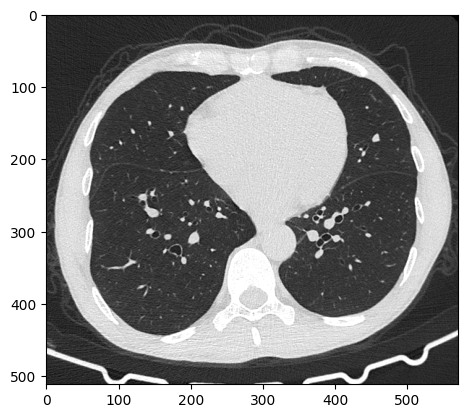

In [85]:
x = read_dicomR(files[0])
plt.imshow(x, cmap = plt.cm.gray)
plt.imsave('testex.png',x , cmap = plt.cm.gray)
x

In [90]:

#os.makedirs(os.path.join(BASE,'png'))
f_bug = []
for g in groups:
    paths = df[df['id'] == g]['path']
    path_base = os.path.join(BASE,'png',g )
    if not os.path.exists(path_base):
        os.makedirs( path_base )
    for i, f in enumerate( files):
        try:
            # dcm = pydicom.read_file(f)
            # img = dcm.pixel_array
            # img = apply_modality_lut(dcm.pixel_array, dcm)
            img = read_dicomR(f)
            plt.imsave( os.path.join(path_base,'dicom_{}.png'.format( f[-8:].split('.')[0] ) ),img , cmap = plt.cm.gray)
        except:
            print( f)
            f_bug.append(f)

/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001523.dcm
/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001519.dcm
/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001523.dcm
/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001519.dcm
/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001523.dcm
/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001519.dcm
/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001523.dcm
/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001519.dcm
/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001523.dcm
/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001519.dcm
/Users/rps

In [36]:
f[-8:].split('.')[0]

'0985'

In [45]:
f = files[0]
dcm = pydicom.read_file(f)
img = dcm.pixel_array
cv2.imshow('x',img)
cv2.imwrite('teste.png', img)

True

In [93]:
x = pydicom.dcmread('/Users/rps/Downloads/MV_1149275/DICOM/1.3.12.2.1107.5.1.7.156306.30000022110817355403500001519.dcm')
val = x.get('PhotometricInterpretation')
try:
    if val is None: # The variable
        print('It is None')
except NameError:
    print ("This variable is not defined")
else:
    print ("It is defined and has a value")

It is None
It is defined and has a value
